Finetuning to follow instructions

In [31]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # 绘图库
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # 进度条
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.3.2
matplotlib version: 3.10.5
tiktoken version: 0.11.0
torch version: 2.8.0+cu129
tqdm version: 4.67.1
tensorflow version: 2.20.0


Preparing a dataset for supervised instruction finetuning

In [32]:
import json
import os
import urllib
# 下载和加载数据集
def download_and_load_file(file_path,url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path,"w",encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path,"r",encoding="utf-8") as file:
        data = json.load(file)

    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path,url)
print("Number of entries:",len(data))
print(data[0])#数据格式为 Alpaca 风格，包含 instruction 、 input(可选) 、 output

Number of entries: 1100
{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}


In [33]:
# 格式化输入数据，修改为模型学习的标准格式
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text
model_input = format_input(data[50])
desired_reponse = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_reponse)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [34]:
# 划分数据集
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:",len(train_data))
print("Validation set length:",len(val_data))
print("Test set length:",len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


Organizing data into training batches

In [35]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self,data,tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))# 将拼接好的完整文本进行编码并添加到 encoded_texts

    def __getitem__(self,index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [36]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

[50256]


In [37]:
# 只生成 input ，没有 target
def custom_collate_draft_1(batch,pad_token_id=50256,device="cuda"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]#在句末添加一个结束符
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))#添加结束符保证一个 batch 内所有样本长度一致
        inputs = torch.tensor(padded[:-1])# 输入 inputs 是从第一个token到倒数第二个token
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [38]:
# 生成 input 和 target ，但会计算填充部分的 loss ，造成误差
def custom_collate_draft_2(batch,pad_token_id=50256,device="cuda"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst,targets_lst = [],[]
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])# 输入 inputs 是从第一个token到倒数第二个token
        targets = torch.tensor(padded[1:])# 目标 targets 是从第二个token到最后一个token
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor,targets_tensor

In [39]:
# 忽略填充部分的 loss ，pytorch 交叉熵会忽略标签为-100的位置
def custom_collate_fn(batch,pad_token_id=50256,ignore_index=-100,allowed_max_length=None,device="cuda"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst,targets_lst = [],[]
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        #如果超过一个填充符，则把第一个填充符之外的填充符都替换为-100
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor,targets_tensor

In [40]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
inputs = custom_collate_draft_1(batch)
print(inputs)
inputs,targets = custom_collate_draft_2(batch)
# print(inputs)
print(targets)
inputs,targets = custom_collate_fn(batch)
# print(inputs)
print(targets)
#将填充符ID从 50256 切换为 -100 的意义是减少计算 loss 值的误差，下面的代码用于验证这样做的效果

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]], device='cuda:0')
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]], device='cuda:0')


In [41]:
logits_1 = torch.tensor(
    [[-1.0,1.0],
    [-0.5,1.5]]
)
targets_1 = torch.tensor([0,1])
loss_1 = torch.nn.functional.cross_entropy(logits_1,targets_1)

logits_2 = torch.tensor(
    [[-1.0,1.0],
     [-0.5,1.5],
     [-0.5,1.5]]
)
targets_2 = torch.tensor([0,1,1])
loss_2 = torch.nn.functional.cross_entropy(logits_2,targets_2)

targets_3 = torch.tensor([0,1,-100])
loss_3 = torch.nn.functional.cross_entropy(logits_2,targets_3)

print(loss_1)
print(loss_2)
print(loss_3)

tensor(1.1269)
tensor(0.7936)
tensor(1.1269)


Creating data loaders for an instruction dataset

In [42]:
device = torch.device("cuda")
print(device)

from functools import partial
# partial 可以将一个函数的某些参数固定下来，生成一个新的、更简单的函数
customized_collate_fn = partial(custom_collate_fn,device=device,allowed_max_length=1024)


cuda


In [43]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data,tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,#打乱数据顺序
    drop_last=True,#丢弃不够一个完整 batch 的数据
    num_workers=num_workers
)
val_dataset = InstructionDataset(val_data,tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)
test_dataset = InstructionDataset(test_data,tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)
print("Train loader:")
for inputs,targets in train_loader:
    print(inputs.shape,targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [44]:
print(inputs[0].shape)

torch.Size([69])


In [45]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


Loading a pretrained LLM

In [46]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [49]:
#测试当前模型的指令跟随效果
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)
print("\n\n")

from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=50,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids,tokenizer)

response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'



### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'


Finetuning the LLM on instruction data

In [18]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device,num_batches=5)
    val_loss = calc_loss_loader(val_loader,model,device,num_batches=5)

print("Training loss:",train_loss)
print("Validation loss:",val_loss)

Training loss: 4.167139339447021
Validation loss: 4.050935411453247


In [19]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.119, Val loss 3.069
Ep 1 (Step 000005): Train loss 1.696, Val loss 1.570
Ep 1 (Step 000010): Train loss 1.096, Val loss 1.164
Ep 1 (Step 000015): Train loss 1.053, Val loss 1.083
Ep 1 (Step 000020): Train loss 0.970, Val loss 1.038
Ep 1 (Step 000025): Train loss 0.920, Val loss 1.002
Ep 1 (Step 000030): Train loss 0.960, Val loss 0.978
Ep 1 (Step 000035): Train loss 0.877, Val loss 0.951
Ep 1 (Step 000040): Train loss 0.847, Val loss 0.943
Ep 1 (Step 000045): Train loss 0.777, Val loss 0.925
Ep 1 (Step 000050): Train loss 0.869, Val loss 0.911
Ep 1 (Step 000055): Train loss 0.924, Val loss 0.893
Ep 1 (Step 000060): Train loss 0.873, Val loss 0.877
Ep 1 (Step 000065): Train loss 0.800, Val loss 0.867
Ep 1 (Step 000070): Train loss 0.694, Val loss 0.860
Ep 1 (Step 000075): Train loss 0.706, Val loss 0.856
Ep 1 (Step 000080): Train loss 0.753, Val loss 0.847
Ep 1 (Step 000085): Train loss 0.680, Val loss 0.836
Ep 1 (Step 000090): Train loss 0.729, Val loss

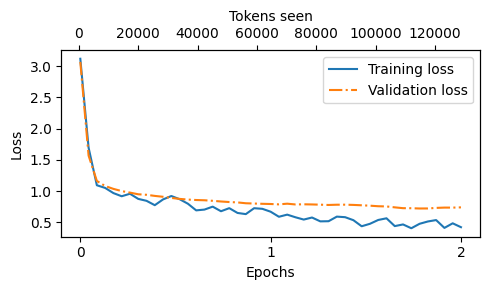

In [20]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor,tokens_seen,train_losses,val_losses)

Extracting and saving response

In [21]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text,tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids,tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a tropical rainforest.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 

In [22]:
from tqdm import tqdm

for i,entry in tqdm(enumerate(test_data),total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text,tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids,tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:","").strip()
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json","w") as file:
    json.dump(test_data,file,indent=4)

100%|██████████| 110/110 [00:31<00:00,  3.46it/s]


In [23]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a horse.'}


In [24]:
import re

file_name = f"{re.sub(r'[ ()]','',CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(),file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-small124M-sft.pth


Evaluating the finetuned LLM

In [26]:
import psutil
# 检查 Ollama 服务
def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running.Launch ollama before proceeding.")
print("Ollama running:",check_if_running("ollama"))

Ollama running: True


In [27]:
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path,"r") as file:
    test_data = json.load(file)

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [28]:
import urllib.request

def query_model(
        prompt,
        model="llama3",
        url="http://localhost:11434/api/chat"
    ):
    data = {
        "model":model,
        "messages":[
            {"role":"user","content":prompt}
        ],
        "options":{
            "seed":123,
            "temperature":0,
            "num_ctx":2048
        }
    }
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type","application/json")
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data

model = "llama3"
result = query_model("What do Llamas eat?",model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories and low in fiber.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach. These treats are great for providing essential vitamins and minerals.
5. Minerals: Llamas need access to mineral supplements, which can include salt, calcium, and phosphorus. These minerals help maintain their overall health and strong bone structure.

In the wild, lla

In [29]:
#构建打分提示词
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.

Score:
>> I'd rate the model response "The car is as fast as a horse." an 80 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to that of a horse.
* The comparison is reasonable and relatable, as horses are known for their speed.
* However, the model could have chosen a more vivid or unexpected comparison to make the sentence more engaging. For example, "The car is as fast as a cheetah" might be an even better simile.

Overall, the response is good but not exceptional, which is why I'd give it an 80 out of 100.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a tropical rainforest.

Score:
>> I'd rate this model response a 0 out of 100.

Here's why:

* The instruction asks about th

In [30]:
#批量打分并计算模型平均分
def generate_model_scores(json_data,json_key,model="llama3"):
    scores = []
    for entry in tqdm(json_data,desc="Scoring entries"):
        prompt = (
            f"Given the input '{format_input(entry)}' "
            f"and correct output '{entry['output']}', "
            f"score the model response '{entry[json_key]}' "
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt,model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores

scores = generate_model_scores(test_data,"model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [04:55<00:00,  2.68s/it]

Number of scores: 110 of 110
Average score: 32.45

